# Introduction

In this notebook we demonstrate the use of **LSI (Latent Semantic Indexing)** Information Retrieval technique to make trace link recovery between Use Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each use case content as an entire document that must be returned to the query made

## Import Libraries

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, pairwise_distances, pairwise
from sklearn.externals.joblib import Parallel, delayed
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from scipy.sparse import csr_matrix

import nltk
import datetime
import pprint
from enum import Enum
import pickle

import warnings; warnings.simplefilter('ignore')

### Oracle Loader

In [3]:
class OracleLoader:
    def __init__(self, rows_names, columns_names):
        self.oracle = None
        self._columns_names = columns_names
        self._rows_names = rows_names
    
    def load(self):
        self.oracle = pd.DataFrame(columns=list(self._columns_names), 
                                   data=np.zeros(shape=(len(self._rows_names), len(self._columns_names)), 
                                                 dtype='int64'))
        self.oracle.insert(0, 'artf_name', list(self._rows_names))
        
        for index, row in trace_df.iterrows():
            idx = self.oracle[self.oracle.artf_name == row['trg_artf']].index
            self.oracle.at[idx, row['src_artf']] = row['link']

        self.oracle.set_index('artf_name', inplace=True)

## Load Dataset and Preprocessing

In [4]:
trace_df = pd.read_csv('../../data/jEdit/jEditDataset/oracle/output/trace_matrix.csv')
artfs_desc_df = pd.read_csv('../../data/jEdit/jEditDataset/oracle/output/artifacts_descriptions.csv', sep="|")

use_cases_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Use Case ID')]
bug_reports_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Bug Number')]

corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

use_cases_names = use_cases_df.artf_name
bug_reports_names = bug_reports_df.artf_name

orc = OracleLoader(use_cases_names, bug_reports_names)
orc.load()

# LSI Model

#### Model Hyperparameters

In [5]:
class LSI_Model_Hyperp(Enum):
    NAME = 'lsi__name'
    SIM_MEASURE_MIN_THRESHOLD = 'lsi__sim_measure_min_threshold'
    VECTORIZER = 'lsi__vectorizer'
    VECTORIZER_STOP_WORDS = 'lsi__vectorizer__stop_words'
    VECTORIZER_TOKENIZER = 'lsi__vectorizer__tokenizer'
    VECTORIZER_USE_IDF = 'lsi__vectorizer__use_idf'
    VECTORIZER_SMOOTH_IDF = 'lsi__vectorizer__smooth_idf'
    VECTORIZER_NGRAM_RANGE = 'lsi__vectorizer__ngram_range'
    SVD_MODEL = 'lsi__svd_model'
    SVD_MODEL_N_COMPONENTS = 'lsi__svd_model__n_components'

#### Tokenizers

In [6]:
"""
Others stemmers are not relevant for our analysis:
 . RSLP Stemmer: portuguese language
 . ISRIS Stemmer: returns Arabic root for the given token 
 . Regexp Stemmer: uses regulax expressions to identify morphological affixes
 
Relevant Stemmers/Lemmatizers are implemented below. 
"""

class GenericTokenizer(object):
    def __init__(self):
        self.stopwords = nltk.corpus.stopwords.words('english')
    def __call__(self, doc):
        tokens = [self.stemmer.stem(token) for token in nltk.word_tokenize(doc)]
        #return [token.lower() for token in tokens if token.isalpha() and token not in self.stopwords and len(token) > 1]
        return [token.lower() for token in tokens if token not in self.stopwords]
        
class WordNetBased_LemmaTokenizer(GenericTokenizer):
    def __init__(self):
        super().__init__()
        self.wnl = nltk.stem.WordNetLemmatizer()
    def __call__(self, doc):
        tokens = [self.wnl.lemmatize(token) for token in nltk.word_tokenize(doc)]
        return [token.lower() for token in tokens if token.isalpha() and token not in self.stopwords]

class LancasterStemmerBased_Tokenizer(GenericTokenizer):
    def __init__(self):
        super().__init__()
        self.stemmer = nltk.stem.LancasterStemmer()
    def __call__(self, doc):
        return super().__call__(doc)

class PorterStemmerBased_Tokenizer(GenericTokenizer):
    def __init__(self):
        super().__init__()
        self.stemmer = nltk.stem.PorterStemmer()
    def __call__(self, doc):
        return super().__call__(doc)
    
class SnowballStemmerBased_Tokenizer(GenericTokenizer):    
    def __init__(self):
        super().__init__()
        self.stemmer = nltk.stem.SnowballStemmer('english')    
    def __call__(self, doc):
        return super().__call__(doc)
        

#### Distance Functions / Similarity Measures Available

In [7]:
class SimilarityMeasure(Enum):
    COSINE = 'cosine'
    JACCARD_INDEX = 'jaccard'
    EDIT_DISTANCE = 'edit'

#### Model Definition

In [8]:
"""
params_dict = {
    'lsi__sim_measure_min_threshold' : ('cosine',.9),
    'lsi__name' : 'LSI',
    'lsi__vectorizer' : TfidfVectorizer(),
    'lsi__vectorizer__stop_words' : 'english',
    'lsi__vectorizer__tokenizer' : Tokenizer(),
    'lsi__vectorizer__use_idf' : True,          # optional if type(Vectorizer) == TfidfVectorizer
    'lsi__vectorizer__smooth_idf' : True,       # optional if type(Vectorizer) == TfidfVectorizer
    'lsi__vectorizer__ngram_range' : (1,2),
    'lsi__svd_model' : TruncatedSVD(),
    'lsi__svd_model__n_components' : 5
}
"""
class LSI:
    def __init__(self, **kwargs):
        self._svd_matrix = None
        self._query_vector = None
        
        self.name = None
        self.sim_measure_min_threshold = None
        self.trace_links_df = None
        self.vectorizer = None
        self.svd_model = None
        
        self.set_basic_params(**kwargs)
        self.set_vectorizer(**kwargs)
        self.set_svd_model(**kwargs)
    
    def set_name(self, name):
        self.name = name
    
    def set_basic_params(self, **kwargs):
        self.name = 'LSI' if LSI_Model_Hyperp.NAME.value not in kwargs.keys() else kwargs[LSI_Model_Hyperp.NAME.value]
        self.sim_measure_min_threshold = (SimilarityMeasure.COSINE.value,.80) if LSI_Model_Hyperp.SIM_MEASURE_MIN_THRESHOLD.value not in kwargs.keys() else kwargs[LSI_Model_Hyperp.SIM_MEASURE_MIN_THRESHOLD.value]
    
    def set_vectorizer(self, **kwargs):
        self.vectorizer = TfidfVectorizer(stop_words='english',
                                             use_idf=True, 
                                             smooth_idf=True) if LSI_Model_Hyperp.VECTORIZER.value not in kwargs.keys() else kwargs[LSI_Model_Hyperp.VECTORIZER.value]
        
        vec_params = {key.split('__')[2]:kwargs[key] for key,val in kwargs.items() if '__vectorizer__' in key}
        self.vectorizer.set_params(**vec_params)
    
    def set_svd_model(self, **kwargs):
        self.svd_model = TruncatedSVD(n_components = 100, 
                                         algorithm = 'randomized',
                                         n_iter = 10, 
                                         random_state = 42) if LSI_Model_Hyperp.SVD_MODEL.value not in kwargs.keys() else kwargs[LSI_Model_Hyperp.SVD_MODEL.value]
        
        svd_model_params = {key.split('__')[2]:kwargs[key] for key,val in kwargs.items() if '__svd_model__' in key}
        self.svd_model.set_params(**svd_model_params)
    
    def recover_links(self, corpus, query, use_cases_names, bug_reports_names):
        metric = self.sim_measure_min_threshold[0]
        
        if metric == SimilarityMeasure.COSINE.value:
            return self._recover_links_cosine(corpus, query, use_cases_names, bug_reports_names)
        
        elif metric == SimilarityMeasure.JACCARD_INDEX.value:
            return self._recover_links_jaccard(corpus, query, use_cases_names, bug_reports_names)
        
        elif metric == SimilarityMeasure.EDIT_DISTANCE.value:
            return self._recover_links_edit(corpus, query, use_cases_names, bug_reports_names)
    
    def _recover_links_cosine(self, corpus, query, use_cases_names, bug_reports_names):
        svd_transformer = Pipeline([('vec', self.vectorizer), 
                            ('svd', self.svd_model)])

        self._svd_matrix = svd_transformer.fit_transform(corpus)
        self._query_vector = svd_transformer.transform(query)
        self._sim_matrix = pairwise.cosine_similarity(X=self._svd_matrix, Y=self._query_vector)

        self.trace_links_df = pd.DataFrame(index = use_cases_names, 
                                       columns = bug_reports_names,
                                       data = self._sim_matrix)

        for col in self.trace_links_df.columns:
            self.trace_links_df[col] = [1 if x >= self.sim_measure_min_threshold[1] else 0 for x in self.trace_links_df[col]]
    
    def _recover_links_jaccard(self, corpus, query, use_cases_names, bug_reports_names):
        tokenizer = self.vectorizer.tokenizer
                
        corpus_tokens = [tokenizer.__call__(doc) for doc in corpus]        
        query_tokens = [tokenizer.__call__(doc) for doc in query]
        
        self._sim_matrix = pd.DataFrame(index = use_cases_names, 
                                       columns = bug_reports_names,
                                       data = np.zeros(shape=(len(use_cases_names), len(bug_reports_names)), dtype='int64'))
        
        self.trace_links_df = pd.DataFrame(index = use_cases_names, 
                                       columns = bug_reports_names,
                                       data = self._sim_matrix)
        
        for br_id, doc_query_tset in zip(bug_reports_names, query_tokens):
            for uc_id, doc_corpus_tset in zip(use_cases_names, corpus_tokens):
                self._sim_matrix.at[uc_id, br_id] = nltk.jaccard_distance(set(doc_corpus_tset), set(doc_query_tset))

        for col in self.trace_links_df.columns:
            self.trace_links_df[col] = [1 if x >= self.sim_measure_min_threshold[1] else 0 for x in self.trace_links_df[col]]
    
    def _recover_links_edit(self, corpus, query, use_cases_names, bug_reports_names):
        self._sim_matrix = pd.DataFrame(index = use_cases_names, 
                                       columns = bug_reports_names,
                                       data = np.zeros(shape=(len(use_cases_names), len(bug_reports_names)), dtype='int64'))
        
        self.trace_links_df = pd.DataFrame(index = use_cases_names, 
                                       columns = bug_reports_names,
                                       data = self._sim_matrix)
        
        for br_id, doc_query in zip(bug_reports_names, query):
            for uc_id, doc_corpus in zip(use_cases_names, corpus):
                self._sim_matrix.at[uc_id, br_id] = nltk.edit_distance(doc_corpus, doc_query)

        for col in self.trace_links_df.columns:
            self.trace_links_df[col] = [1 if x >= self.sim_measure_min_threshold[1] else 0 for x in self.trace_links_df[col]]
    
    def model_setup(self):
        return {"Setup" : 
                  [
                      {"Name" : self.name},
                      {"Similarity Measure and Minimum Threshold" : self.sim_measure_min_threshold},
                      {"SVD Model" : self.svd_model.get_params()},
                      {"Vectorizer" : self.vectorizer.get_params()},
                      {"Vectorizer Type" : type(self.vectorizer)}
                  ]
               }
    
    def get_name(self):
        return self.name
    
    def get_query_vector(self):
        return self._query_vector
    
    def get_svd_matrix(self):
        return self._svd_matrix
    
    def get_sim_matrix(self):
        return self._sim_matrix
    
    def get_sim_measure_min_threshold(self):
        return self.sim_measure_min_threshold
    
    def get_trace_links_df(self):
        return self.trace_links_df
    
    def get_vectorizer_type(self):
        return type(self.vectorizer)
    
    def get_tokenizer_type(self):
        return type(self.vectorizer.tokenizer)

### Model Evaluator

In [9]:
class ModelEvaluator:
    def __init__(self, oracle, model):
        self.model = model
        self.oracle = oracle
        self.recovered_links = model.trace_links_df
        
        self.eval_df = pd.DataFrame(columns=['precision','recall','fscore','support'])
        self.mean_precision = -1
        self.mean_recall = -1
        self.mean_fscore = -1
    
    def evaluate_model(self, verbose=False, file=None):
        y_true = csr_matrix(self.oracle.values, dtype=int)
        y_pred = csr_matrix(self.recovered_links.values, dtype=int)
        
        p, r, f, sp = precision_recall_fscore_support(y_true, y_pred)

        i = 0
        for idx, row in self.oracle.iteritems():
            self.eval_df.at[idx, 'precision'] = p[i]
            self.eval_df.at[idx, 'recall'] = r[i]
            self.eval_df.at[idx, 'fscore'] = f[i]
            self.eval_df.at[idx, 'support'] = sp[i]
            i += 1
        
        self.mean_precision = self.eval_df.precision.mean()
        self.mean_recall = self.eval_df.recall.mean()
        self.mean_fscore = self.eval_df.fscore.mean()
        
        if verbose:
            self.print_report(file)
    
    def check_best_model(self, best_pre, best_rec, best_fs, best_md):
        if best_rec <= self.get_mean_recall():
            if best_pre <= self.get_mean_precision():
                return (self.get_mean_precision(), self.get_mean_recall(), self.get_mean_fscore(), self.get_model())
        return (best_pre, best_rec, best_fs, best_md)
    
    def print_report(self, file=None):
        dic = self.model.model_setup()
        dic['Measures'] = {}
        dic['Measures']['Mean Precision of {}'.format(self.model.get_name())] = self.get_mean_precision()
        dic['Measures']['Mean Recall of {}'.format(self.model.get_name())] = self.get_mean_recall()
        dic['Measures']['Mean FScore of {}'.format(self.model.get_name())] = self.get_mean_fscore()
        
        if file is None:    
            pprint.pprint(dic)
        else:
            file.write(pprint.pformat(dic))
        
    def plot_precision_vs_recall(self):
        plt.figure(figsize=(6,6))
        plt.plot(self.eval_df.recall, self.eval_df.precision, 'ro', label='Precision vs Recall')

        plt.ylabel('Precision')
        plt.xlabel('Recall')

        plt.axis([0, 1.1, 0, 1.1])
        plt.title("Precision vs Recall Plot - " + self.model.get_name())
        plt.show()
    
    def save_log(self):
        print("\nSaving model log...")
        with open('../logs/' + str(datetime.datetime.now()) + '.txt', 'a') as f:
            evaluator.evaluate_model(verbose=True, file=f)
        print("Model log saved with success!")
            
    def get_mean_precision(self):
        return self.mean_precision
    
    def get_mean_recall(self):
        return self.mean_recall
    
    def get_mean_fscore(self):
        return self.mean_fscore

    def get_model(self):
        return self.model

## Evaluate Recovering Efficiency

In order to evaluate the efficiency of the algorithm tested (LSI), we use common metrics applied in the field of IR:

    * Precision
    * Recall
    * F1-score

### Analysis with Default Values of LSI Model

In [10]:
best_model = LSI()
best_model.recover_links(corpus, query, use_cases_names, bug_reports_names)
evaluator = ModelEvaluator(orc.oracle, best_model)
evaluator.evaluate_model(verbose=True)
#evaluator.plot_precision_vs_recall()

{'Measures': {'Mean FScore of LSI': 0.5714285714285714,
              'Mean Precision of LSI': 0.6428571428571429,
              'Mean Recall of LSI': 0.5357142857142857},
 'Setup': [{'Name': 'LSI'},
           {'Similarity Measure and Minimum Threshold': ('cosine', 0.8)},
           {'SVD Model': {'algorithm': 'randomized',
                          'n_components': 100,
                          'n_iter': 10,
                          'random_state': 42,
                          'tol': 0.0}},
           {'Vectorizer': {'analyzer': 'word',
                           'binary': False,
                           'decode_error': 'strict',
                           'dtype': <class 'numpy.int64'>,
                           'encoding': 'utf-8',
                           'input': 'content',
                           'lowercase': True,
                           'max_df': 1.0,
                           'max_features': None,
                           'min_df': 1,
                         

### Auxiliary Functions

In [71]:
from itertools import product

def generate_params_comb_list(**kwargs):
    list_params = []
    for key, values in kwargs.items():
        aux_list = []
        for v in values:
            aux_list.append((key, v))
        list_params.append(aux_list)
    
    list_tuples = list(product(*list_params))
    
    list_dicts = []
    for ex_tup in list_tuples:
        dic = {}
        for in_tup in ex_tup:
            dic[in_tup[0]] = in_tup[1]
        list_dicts.append(dic)
        
    return list_dicts


def plot_heatmap(results_df):
    tmp_df = pd.DataFrame({'precision': results_df['precision'], 
                           'recall' : results_df['recall'], 
                           'fscore': results_df['fscore'], 
                           'model': results_df['model_name']})
    tmp_df.set_index('model', inplace=True)
    fig, ax = plt.subplots(figsize=(10, 4 * 100)) 
    ax = sns.heatmap(tmp_df, vmin=0, vmax=1, linewidths=.5, cmap="Greens", annot=True, cbar=False, ax=ax)


def highlight_df(df):
    cm = sns.light_palette("green", as_cmap=True)
    return df.style.background_gradient(cmap=cm)    

### Quick Test Jaccard Values

In [12]:
all_hyperparams = {
    LSI_Model_Hyperp.VECTORIZER_NGRAM_RANGE.value: [(1,1)],
    LSI_Model_Hyperp.VECTORIZER.value : [TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)],
    LSI_Model_Hyperp.VECTORIZER_TOKENIZER.value : [PorterStemmerBased_Tokenizer()],
    LSI_Model_Hyperp.SIM_MEASURE_MIN_THRESHOLD.value : [('jaccard',x) for x in [.8]],
}

hyperparams = generate_params_comb_list(**all_hyperparams)

print('Performing model optimizations...')
best_precision = -1
best_recall = -1
best_fscore = -1
best_model = None

results = {'precision': [], 'recall': [], 'fscore': [], 'model': []}

i = 0
for hyperp in hyperparams:
    hyperp[LSI_Model_Hyperp.NAME.value] = 'LSI_Model_{}'.format(i)
    current_model = LSI(**hyperp)
    current_model.recover_links(corpus, query, use_cases_names, bug_reports_names)
    
    evaluator = ModelEvaluator(orc.oracle, current_model)
    evaluator.evaluate_model()

    if best_recall <= evaluator.get_mean_recall():
        if best_precision <= evaluator.get_mean_precision():
            best_recall = evaluator.get_mean_recall()
            best_precision = evaluator.get_mean_precision()
            best_fscore = evaluator.get_mean_fscore()
            best_model = current_model
    
    results['precision'].append(evaluator.get_mean_precision())
    results['recall'].append(evaluator.get_mean_recall())
    results['fscore'].append(evaluator.get_mean_fscore())
    results['model'].append(current_model.get_name())
    
    i += 1 
    
print("------------ Report -------------------\n")
print("Total of Analyzed Hyperparameters Combinations: {}".format(len(hyperparams)))

print("\nBest Model and Hyperparameters Found: {}\n".format(best_model.get_name()))            
evaluator = ModelEvaluator(orc.oracle, best_model)
evaluator.evaluate_model(verbose=True)

#print("\nHeatmap of All Models")
#plot_heatmap(results)

Performing model optimizations...
------------ Report -------------------

Total of Analyzed Hyperparameters Combinations: 1

Best Model and Hyperparameters Found: LSI_Model_0

{'Measures': {'Mean FScore of LSI_Model_0': 0.0,
              'Mean Precision of LSI_Model_0': 0.0,
              'Mean Recall of LSI_Model_0': 0.0},
 'Setup': [{'Name': 'LSI_Model_0'},
           {'Similarity Measure and Minimum Threshold': ('jaccard', 0.8)},
           {'SVD Model': {'algorithm': 'randomized',
                          'n_components': 100,
                          'n_iter': 10,
                          'random_state': 42,
                          'tol': 0.0}},
           {'Vectorizer': {'analyzer': 'word',
                           'binary': False,
                           'decode_error': 'strict',
                           'dtype': <class 'numpy.int64'>,
                           'encoding': 'utf-8',
                           'input': 'content',
                           'lowercase

### Find The Best Model

Performing model hyperparameters search...


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   17.8s finished


------------ Report -------------------

Total of Analyzed Hyperparameters Combinations: 480

Best Model and Hyperparameters Found:

{'Measures': {'Mean FScore of LSI_Model_0': 0.5916666666666667,
              'Mean Precision of LSI_Model_0': 0.4678571428571429,
              'Mean Recall of LSI_Model_0': 0.9285714285714286},
 'Setup': [{'Name': 'LSI_Model_0'},
           {'Similarity Measure and Minimum Threshold': ('cosine', 0.75)},
           {'SVD Model': {'algorithm': 'randomized',
                          'n_components': 5,
                          'n_iter': 10,
                          'random_state': 42,
                          'tol': 0.0}},
           {'Vectorizer': {'analyzer': 'word',
                           'binary': False,
                           'decode_error': 'strict',
                           'dtype': <class 'numpy.int64'>,
                           'encoding': 'utf-8',
                           'input': 'content',
                           'lowercase'

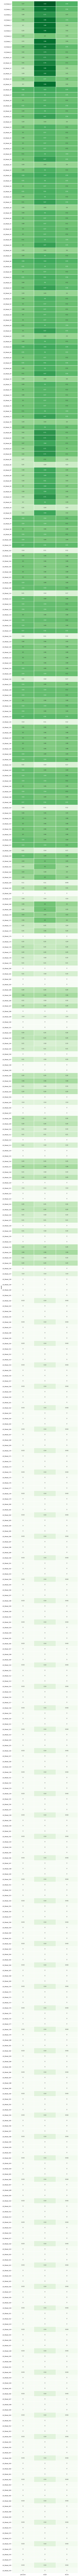

In [72]:
all_hyperparams = {
    LSI_Model_Hyperp.SIM_MEASURE_MIN_THRESHOLD.value : [('cosine' ,x)  for x in [.75,.85,.95]] +
                                                       [('jaccard',x)  for x in [.55,.75,.90]],
                                                       #[('edit',x)    for x in [.55,.75,.90]],
    LSI_Model_Hyperp.SVD_MODEL_N_COMPONENTS.value: [5,10,20,50,90],
    LSI_Model_Hyperp.VECTORIZER_NGRAM_RANGE.value: [(1,1), (1,2)],
    LSI_Model_Hyperp.VECTORIZER.value : [TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True), 
                         CountVectorizer(stop_words='english')],
    LSI_Model_Hyperp.VECTORIZER_TOKENIZER.value : [PorterStemmerBased_Tokenizer(), LancasterStemmerBased_Tokenizer(), 
                                                   WordNetBased_LemmaTokenizer(), SnowballStemmerBased_Tokenizer()]
}

hyperparams = generate_params_comb_list(**all_hyperparams)          

print('Performing model hyperparameters search...')
best_precision = -1
best_recall = -1
best_fscore = -1
best_model = None

def run_model(idx, **hyperp):    
    current_model = LSI(**hyperp)
    current_model.set_name('LSI_Model_{}'.format(idx))
    current_model.recover_links(corpus, query, use_cases_names, bug_reports_names)
    
    evaluator = ModelEvaluator(orc.oracle, current_model)
    evaluator.evaluate_model()
    
    model_dump = 'dumps/model/{}.p'.format(evaluator.get_model().get_name())
    evaluator_dump = 'dumps/evaluator/eval_{}.p'.format(evaluator.get_model().get_name())
    
    pickle.dump(evaluator.get_model(), open(model_dump, 'wb'))
    pickle.dump(evaluator, open(evaluator_dump, 'wb'))
    
    return([evaluator.get_mean_precision(), 
                    evaluator.get_mean_recall(),
                    evaluator.get_mean_fscore(), 
                    evaluator.get_model().get_name(),
                    evaluator.get_model().get_vectorizer_type(), 
                    evaluator.get_model().get_tokenizer_type(),
                    evaluator.get_model().get_sim_measure_min_threshold()[0],
                    evaluator.get_model().get_sim_measure_min_threshold()[1],
                    model_dump,
                    evaluator_dump
           ])

tasks = [(idx,hp) for idx,hp in enumerate(hyperparams)]
results = Parallel(n_jobs=-1, verbose=1)(delayed(run_model)(idx, **hp) for idx,hp in tasks)
results_df = pd.DataFrame(data=results, 
                          columns=['precision', 'recall', 'fscore', 'model_name', 'vectorizer', 'tokenizer', 'metric', 'metric_value', 'model_dump', 'evaluator_dump'])
results_df = results_df.astype(dtype={'model_dump' : str, 'evaluator_dump' : str})


print("------------ Report -------------------\n")
print("Total of Analyzed Hyperparameters Combinations: {}".format(len(hyperparams)))

print("\nBest Model and Hyperparameters Found:\n")            

row_idx = results_df['model_dump'][results_df.recall == results_df.recall.max()].index[0]
best_model = pickle.load(open(results_df['model_dump'][row_idx], 'rb'))
evalu = pickle.load(open(results_df['evaluator_dump'][row_idx], 'rb'))
evalu.evaluate_model(verbose=True)

#print("\nPlot Precision vs Recall - Best Model")
#evalu.plot_precision_vs_recall()

#print("\nHeatmap of All Models")
#plot_heatmap(results_df)

#evalu.save_log()

### Plot Highlights

In [73]:
highlight_df(best_model.get_trace_links_df())

artf_name,BR_4020_SRC,BR_3890_SRC,BR_3844_SRC,BR_4065_SRC,BR_3880_SRC,BR_3987_SRC,BR_4067_SRC,BR_3973_SRC,BR_3898_SRC,BR_3908_SRC,BR_4058_SRC,BR_4018_SRC,BR_4005_SRC,BR_3974_SRC
artf_name,,,,,,,,,,,,,,
UC_003_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_007_TRG,0,0,0,0,0,0,0,0,0,0,1,0,0,0
UC_010_TRG,0,0,1,0,0,1,0,0,1,1,0,0,0,0
UC_002_TRG,1,1,0,0,1,1,1,1,0,0,0,1,0,1
UC_006_TRG,1,1,0,0,1,1,1,1,0,0,0,1,0,1
UC_004_TRG,1,1,0,1,1,1,1,1,0,0,0,1,0,1
UC_005_TRG,1,1,0,0,1,1,1,1,0,0,0,1,0,1
UC_008_TRG,0,0,0,1,1,0,0,0,0,0,0,0,1,0
UC_001_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
highlight_df(orc.oracle)

,BR_4020_SRC,BR_3890_SRC,BR_3844_SRC,BR_4065_SRC,BR_3880_SRC,BR_3987_SRC,BR_4067_SRC,BR_3973_SRC,BR_3898_SRC,BR_3908_SRC,BR_4058_SRC,BR_4018_SRC,BR_4005_SRC,BR_3974_SRC
artf_name,,,,,,,,,,,,,,
UC_003_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UC_007_TRG,0,0,0,0,0,0,0,0,0,0,1,0,0,0
UC_010_TRG,0,0,1,0,0,0,0,0,0,0,0,0,0,0
UC_002_TRG,0,0,0,0,1,0,0,1,0,0,0,0,0,0
UC_006_TRG,1,1,0,1,1,0,0,0,0,0,0,1,0,1
UC_004_TRG,0,0,0,0,0,1,0,0,0,0,0,0,0,0
UC_005_TRG,1,1,0,0,1,0,1,0,0,0,0,1,0,0
UC_008_TRG,0,0,0,0,0,0,0,0,0,0,0,0,1,0
UC_001_TRG,0,0,0,0,0,0,0,0,0,0,0,0,0,0
